## **Homework 1**

# Exersice 1

In [ ]:
!pip install networkx
!pip install cvxpy

In [ ]:
pip install picos

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.7/510.7 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for picos: filename=PICOS-2.4.17-py3-none-any.whl size=472080 sha256=4b994b08caa1ecfac9b96981aff8f32b415f5ac19e75b50c26f6401a4e046bca
  Stored in directory: /root/.cache/pip/wheels/fb/af/b5/19872af62fd4c1cc6d17a63cd457017e91db4b410614bc4175
Successfully built picos


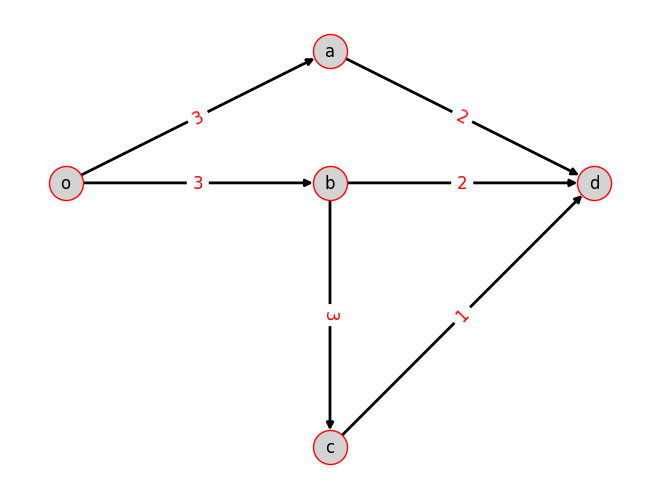

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Create the directed graph as described in your previous code
G = nx.DiGraph()
G.add_edges_from([("o","a"), ("o","b"), ("a","d"), ("b","d"), ("b","c"), ("c","d")])

# Add edge capacities to the graph
capacities = {("o", "a"): 3, ("o", "b"): 3, ("b", "c"): 3, ("a", "d"): 2, ("b", "d"): 2, ("c", "d"): 1}
nx.set_edge_attributes(G, capacities, 'capacity')

# Specify the position for vertices
pos = {"o": [0, 2], "a": [1, 3], "b": [1, 2], "c": [1, 0], "d": [2, 2]}

# Draw the graph
labels = nx.get_edge_attributes(G, 'capacity')

nx.draw(G, pos, with_labels=True, node_size=600, font_size=12, node_color='lightgray', width=2,
        edge_color='black', edgecolors='red')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=12, font_color='red')

# Show the plot
plt.show()

## Exersice 1-1

Minimum aggregate capacity to remove: 5
Minimum cut partition: ({'o', 'a', 'c', 'b'}, {'d'})


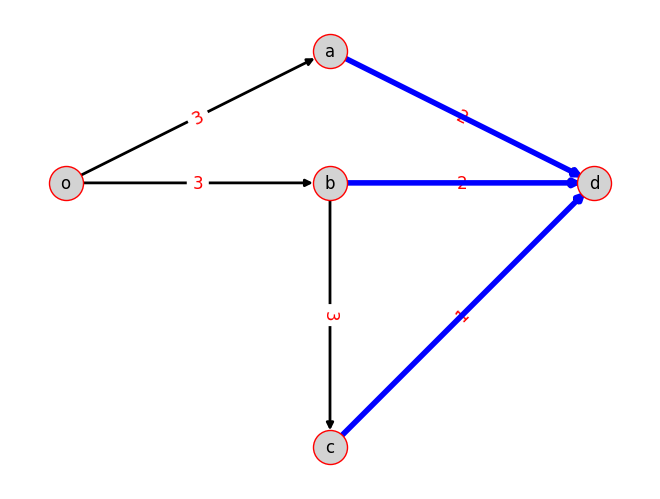

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt


# Create the directed graph as described in your previous code
G = nx.DiGraph()
G.add_edges_from([("o","a"), ("o","b"), ("a","d"), ("b","d"), ("b","c"), ("c","d")])

# Add edge capacities to the graph
capacities = {("o", "a"): 3, ("o", "b"): 3, ("b", "c"): 3, ("a", "d"): 2, ("b", "d"): 2, ("c", "d"): 1}
nx.set_edge_attributes(G, capacities, 'capacity')

# Specify the position for vertices
pos = {"o": [0, 2], "a": [1, 3], "b": [1, 2], "c": [1, 0], "d": [2, 2]}

# Draw the graph
labels = nx.get_edge_attributes(G, 'capacity')

nx.draw(G, pos, with_labels=True, node_size=600, font_size=12, node_color='lightgray', width=2,
        edge_color='black', edgecolors='red')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=12, font_color='red')



# Find the minimum cut
cut_value, partition = nx.minimum_cut(G, "o", "d")

# Calculate the minimum aggregate capacity to remove
min_capacity_to_remove = sum(G[u][v]['capacity'] for u, v in G.edges if u in partition[0] and v in partition[1])
print("Minimum aggregate capacity to remove:", min_capacity_to_remove)

# Display the two sets of nodes that define the minimum cut
print("Minimum cut partition:", partition)

# Highlight the edges in the minimum cut
cut_edges = [(u, v) for u, v in G.edges if u in partition[0] and v in partition[1]]
nx.draw_networkx_edges(G, pos, edgelist=cut_edges, width=4, edge_color='blue')

# Show the plot
plt.show()


## Exersice 1-2

In [ ]:
nx.algorithms.flow.maximum_flow(G,"o","d")

(5,
 {'o': {'a': 2, 'b': 3},
  'a': {'d': 2},
  'b': {'d': 2, 'c': 1},
  'd': {},
  'c': {'d': 1}})

## Exersice 1-3

In [ ]:
!pip install picos
!pip install swiglpk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 22.4 MB/s eta 0:00:00


In [ ]:
import picos as pc

for x in range(0, 10):
  # Extra capacity available
  gamma = x

  # Extracting capacities as dictionary
  c = {}
  for e in sorted(G.edges(data=True)):
    capacity = e[2]['capacity']
    c[(e[0], e[1])]  = capacity

  # Convert the capacities to a PICOS expression.
  cc = pc.new_param('c',c)

  s, t = 'o', 'd'

  maxflow=pc.Problem()

  # Add the flow variables.
  f={}
  for e in G.edges():
    f[e]=maxflow.add_variable('f[{0}]'.format(e))

  # Add the extra capacity variable
  ex={}
  for e in G.edges():
    ex[e]=maxflow.add_variable('ex[{0}]'.format(e))

  # Add the objective variable for the total flow.
  F=maxflow.add_variable('F')

  # CONSTRAINTS
  # Enforce flow conservation.
  maxflow.add_list_of_constraints([
      pc.sum([f[p,i] for p in G.predecessors(i)])
      == pc.sum([f[i,j] for j in G.successors(i)])
      for i in G.nodes() if i not in (s,t)])

  # Set source flow at s.
  maxflow.add_constraint(
    pc.sum([f[p,s] for p in G.predecessors(s)]) + F
    == pc.sum([f[s,j] for j in G.successors(s)]))

  # Set sink flow at t.
  maxflow.add_constraint(
    pc.sum([f[p,t] for p in G.predecessors(t)])
    == pc.sum([f[t,j] for j in G.successors(t)]) + F)

  # Enforce flow nonnegativity.
  maxflow.add_list_of_constraints([f[e] >= 0 for e in G.edges()])

  # Enforce edge capacities.
  maxflow.add_list_of_constraints([f[e] <= cc[e] + ex[e] for e in G.edges()])

  # Enforce extra capacity nonnegativity.
  maxflow.add_list_of_constraints([ex[e] >= 0 for e in G.edges()])

  # Set extra capacity value constraint.
  maxflow.add_constraint(pc.sum([ex[e] for e in G.edges()]) <= gamma)

  # Set the objective.
  maxflow.set_objective('max', F)

  # Solve the problem.
  maxflow.solve(solver='glpk')

import math
import random

print(math.floor(F))

for val in ex.items():
  print(val[0], round(val[1]))

<ipython-input-14-95aec6b4e263>:14: DeprecationWarning: new_param is deprecated: Use picos.Constant instead.
  cc = pc.new_param('c',c)
<ipython-input-14-95aec6b4e263>:23: DeprecationWarning: Problem.add_variable is deprecated: Variables can now be created independent of problems, and do not need to be added to any problem explicitly.
  f[e]=maxflow.add_variable('f[{0}]'.format(e))
<ipython-input-14-95aec6b4e263>:28: DeprecationWarning: Problem.add_variable is deprecated: Variables can now be created independent of problems, and do not need to be added to any problem explicitly.
  ex[e]=maxflow.add_variable('ex[{0}]'.format(e))
<ipython-input-14-95aec6b4e263>:31: DeprecationWarning: Problem.add_variable is deprecated: Variables can now be created independent of problems, and do not need to be added to any problem explicitly.
  F=maxflow.add_variable('F')


10
('o', 'a') 4
('o', 'b') 0
('a', 'd') 5
('b', 'd') 0
('b', 'c') 0
('c', 'd') 0


# Exersice 2

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

def create_bipartite_graph():
    G = nx.DiGraph()
    edges = [("p1", "b1"), ("p1", "b2"), ("p2", "b2"), ("p2", "b3"),
             ("p3", "b1"), ("p3", "b4"), ("p4", "b1"), ("p4", "b2"), ("p4", "b4")]
    G.add_edges_from(edges)
    return G

def visualize_bipartite_graph(G):
    fig, ax = plt.subplots(figsize=(4, 4))

    pos = {"p1": [0, 2], "p2": [0, 1], "p3": [0, 0], "p4": [0, -1],
           "b1": [1, 2], "b2": [1, 1], "b3": [1, 0], "b4": [1, -1]}

    nx.draw(G, pos, node_size=600, font_size=12, node_color='lightblue', with_labels=True, width=2,
            edge_color='black', edgecolors='red', ax=ax)

    plt.savefig("plot2.1.svg", format="svg")
    plt.show()

# Create and visualize the bipartite graph
G_bipartite = create_bipartite_graph()
visualize_bipartite_graph(G_bipartite)

## Exersice 2-1

In [ ]:
# Create a directed graph
G = nx.DiGraph()
# Add nodes for the source and sink
G.add_node('s')
G.add_node('t')

# Add edges from source to people
people = ['p1', 'p2', 'p3', 'p4']
for person in people:
    G.add_edge('s', person, capacity=1)

# Define the interests of each person
interests = {
    'p1': ['b1', 'b2'],
    'p2': ['b2', 'b3'],
    'p3': ['b1', 'b4'],
    'p4': ['b1', 'b2', 'b4']
}

# Add edges from people to books they are interested in
for person, books in interests.items():
    for book in books:
        G.add_edge(person, book, capacity=1)

# Add edges from books to sink
books = ['b1', 'b2', 'b3', 'b4']
for book in books:
    G.add_edge(book, 't', capacity=1)

# Calculate the maximum flow
flow_value, flow_dict = nx.maximum_flow(G, 's', 't')

# Check if there's a perfect matching
perfect_matching_exists = flow_value == len(people)
matching = {}

# If there's a perfect matching, extract it
if perfect_matching_exists:
    for person in people:
        for book, flow in flow_dict[person].items():
            if flow > 0:  # If the flow is greater than 0, then the book is matched to the person
                matching[person] = book

# Output the matching
print("Perfect matching exists:", perfect_matching_exists)
print("Matching pairs:")
for person, book in matching.items():
    print(f"{person} -> {book}")



# Define edge colors and node positions
edge_colors = ["black", "black", "black", "black", "black", "red", "black", "red", "red", "black", "black", "black", "red", "black", "black", "black", "black"]
position = {"p1": [0, 2], "p2": [0, 1], "p3": [0, 0], "p4": [0, -1], "b1": [1, 2], "b2": [1, 1], "b3": [1, 0], "b4": [1, -1], "s": [-1, 0.5], "t": [2, 0.5]}

# Visualize the graph
labels = nx.get_edge_attributes(G, 'capacity')
nx.draw(G, pos=position, with_labels=True, node_size=700, node_color='skyblue', font_size=8, edge_color=edge_colors)
nx.draw_networkx_edge_labels(G, position, edge_labels=labels)

plt.show()

## Exersice 2-2

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Define the new capacities for the edges from books to sink (number of copies for each book)
book_copies = {'b1': 2, 'b2': 3, 'b3': 2, 'b4': 2}

# Create a new directed graph
G = nx.DiGraph()

# Add nodes for the source and sink
G.add_node('s')
G.add_node('t')

# Add edges from source to people with specified capacities
people_capacities = {'p1': 2, 'p2': 3, 'p3': 2, 'p4': 2}
for person, capacity in people_capacities.items():
    G.add_edge('s', person, capacity=capacity)

# Define the interests of each person
interests = {
    'p1': ['b1', 'b2'],
    'p2': ['b2', 'b3'],
    'p3': ['b1', 'b4'],
    'p4': ['b1', 'b2', 'b4']
}

# Add edges from people to books they are interested in with capacity of 1
for person, books in interests.items():
    for book in books:
        G.add_edge(person, book, capacity=1)

# Add edges from books to sink with the updated capacities
books = ['b1', 'b2', 'b3', 'b4']
for book, copies in book_copies.items():
    G.add_edge(book, 't', capacity=copies)


# Output the total number of books assigned
flow_value, _ = nx.maximum_flow(G, 's', 't')
print("Total number of books that can be assigned:", flow_value)

# Define node positions for better visualization
position = {'s': (-1, 0.5), 't': (2, 0.5), 'p1': (0, 2), 'p2': (0, 1), 'p3': (0, 0), 'p4': (0, -1),
            'b1': (1, 2), 'b2': (1, 1), 'b3': (1, 0), 'b4': (1, -1)}

# Visualize the graph
labels = nx.get_edge_attributes(G, 'capacity')
nx.draw(G, pos=position, with_labels=True, node_size=700, node_color='skyblue', font_size=8, edge_color='black')
nx.draw_networkx_edge_labels(G, position, edge_labels=labels)

plt.show()

## Exersice 2-3

In [ ]:
nodes = G.nodes  # store nodes
edges = G.edges  # store edges

for node_i in nodes:

    inflow = 0  # no of input edge
    outflow = 0  # no of output edge

    # source node is not considered
    if node_i == "s":
        continue

    # person nodes are not considered
    if node_i in ["p1", "p2", "p3", "p4"]:
        continue

    # calculate inflow of node_i (Book nodes)
    for u, v, data in G.in_edges(node_i, data=True):
        inflow = sum(data.values()) + inflow

    # calculate outflow of node_i (Book nodes)
    for u, v, data in G.out_edges(node_i, data=True):
        outflow = sum(data.values()) + outflow

    # print inflow and outflow of node_i (Book nodes)
    print(f"{node_i} inflow: {inflow}")
    print(f"{node_i} outflow: {outflow}")

    # netflow of node_i (Book nodes)
    netflow = inflow - outflow

    # if some nodes have inflow greater or minor than outflow, means that it has not an optimized flow
    if netflow > 0 and node_i != "s" and node_i != "t":
        print(f"1 copy of the book {node_i} can be sold ")
    elif netflow < 0 and node_i != "s" and node_i != "t":
        print(f"{-netflow} copy of the book {node_i} can be bought ")

# print inflow and outflow of the destination node 't'
inflow_t = sum(data['capacity'] for u, v, data in G.in_edges('t', data=True))
outflow_t = sum(data['capacity'] for u, v, data in G.out_edges('t', data=True))
print("t inflow:", inflow_t)
print("t outflow:", outflow_t)

# print the maximum possible outflow
maxPossibleOutflow = max(inflow_t, 0)
print("Max possible outflow:", maxPossibleOutflow)

# Exersice 3

In [ ]:
# Import necessary libraries
import scipy.io
import cvxpy as cp
import numpy as np
import networkx as nx

# Load data from mat files
flow = scipy.io.loadmat("flow.mat")["flow"].reshape(28,)
capacities = scipy.io.loadmat("capacities.mat")["capacities"].reshape(28,)
traffic = scipy.io.loadmat("traffic.mat")["traffic"]
traveltime = scipy.io.loadmat("traveltime.mat")["traveltime"].reshape(28,)

# Create a directed graph
G2 = nx.DiGraph()

# Populate the graph with edges and capacities based on traffic data
for i in range(traffic.shape[1]):
    for j in range(traffic.shape[0]):
        if traffic[j][i] == 1:  # 1 -> source
            src = j + 1
        elif traffic[j][i] == -1:  # -1 -> destination
            dst = j + 1
    G2.add_edges_from([(src, dst)], capacity=capacities[i])

# Define positions for nodes in the graph
pos = {1: [-2, 1], 2: [-1, 1], 3: [0.5, 1], 4: [2, 1], 5: [4, 0], 6: [-4, -1], 7: [-2.5, -1], 8: [-1, -1], 9: [1, -1],
       10: [-3, -2], 11: [-1, -2], 12: [0.5, -2], 13: [2, -2], 14: [4, -2], 15: [-1.5, -3], 16: [0, -3], 17: [2, -3]}

# Draw the graph using networkx and matplotlib
nx.draw(G2,pos, with_labels=True, node_size=700, node_color='lightgreen', font_size=8, font_color='black', edge_color='darkorange')

##Exercise 3-1

In [ ]:
# Find the shortest path in the graph G2 from source node 1 to target node 17 based on travel time as the weight
shortestPath = nx.shortest_path(G2, source=1, target=17, weight='traveltime')

# Print the result
print("Shortest path from node 1 to node 17: ", shortestPath)

## Exercise 3-2

In [ ]:
# Calculate the maximum flow in the graph G2 from source node 1 to target node 17
maxFlow = nx.algorithms.flow.maximum_flow(G2, 1, 17)

# Print the result
print("Maximum flow from node 1 to node 17: ", maxFlow)

## Exercise 3-3

In [ ]:
# Define the basic variables and matrices for the optimization problem
B = traffic  # B matrix representing the network structure
f = cp.Variable(B.shape[1])  # Variable representing the flow on each edge

# Define exogenous flow vector - unitary inflow from node 1 to node 17
exogenousFlow = np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1])

# Define the travel time vector
traveltime = np.array(traveltime)

# Define the optimization objective - minimize the total travel time
objective = cp.Minimize(traveltime.T @ f)  # Linear combination of the flow values

# Define the constraints for the optimization problem
constraints = [f >= 0, B @ f == exogenousFlow]  # Non-negativity constraint and flow balance constraint

# Solve the optimization problem
cp.Problem(objective, constraints).solve()

# Print the results
print("Optimal value of f:", f.value)  # Optimal flow values
print("External inflow:", B @ flow)  # Total flow on each edge (external inflow)

## Exercise 3-4

In [ ]:
# Define the exogenous inflow vector
exogenousInflow = np.array([16282, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -16282])

# Define the flow variable representing the flow on each edge in the network
f = cp.Variable(B.shape[1])

# Define the cost function to be minimized
costFunction = cp.sum(
    cp.multiply(traveltime * capacities, cp.inv_pos(1 - cp.multiply(f, 1 / capacities))) - traveltime * capacities
)
# The cost function is a combination of travel time, capacities, and flow on each edge

# Define constraints for the optimization problem
# B @ f == exogenousInflow ensures that the flow on each edge, when multiplied by matrix B, equals the specified external inflow vector.
# f <= capacities restricts the flow on each edge to be less than or equal to its capacity.
# f >= 0 enforces that the flow on each edge is non-negative.
constraints = [f >= 0, B @ f == exogenousInflow, f <= capacities]

# Solve the optimization problem to find the optimal flow and cost
cost_optimal = cp.Problem(cp.Minimize(costFunction), constraints).solve()

# Print the results
print("Optimal flow:", f.value)
print("Optimal cost:", cost_optimal)

## Exercise 3-5

In [ ]:
# Define the cost function for Wardrop equilibrium
costFunction2 = cp.sum(-cp.multiply(traveltime * capacities, cp.log(1 - (cp.multiply(f, 1 / capacities)))))
# The cost function represents a form of Wardrop equilibrium in transportation networks

# Define constraints for the optimization problem
# Similar to the previous code, ensuring non-negativity, external inflow, and capacity constraints
constraints2 = [f >= 0, B @ f == exogenousInflow, f <= capacities]

# Solve the optimization problem to find the optimal flow and cost for Wardrop equilibrium
cost_optimal2 = cp.Problem(cp.Minimize(costFunction2), constraints2).solve()

# Print the result
print("Wardrop equilibrium flow:", f.value)

## Exercise 3-6

In [ ]:
# Define a toll function, which is currently set to return the input unchanged
def toll_function(fe):
    return fe

# Calculate tolls based on the optimal flow values from the Wardrop equilibrium
tolls = toll_function(f.value)

# Define the cost function with tolls
costFunction_with_tolls = cp.sum(
    -cp.multiply(traveltime * capacities, cp.log(1 - (cp.multiply(f, 1 / capacities)))) + tolls
)
# The cost function now includes the tolls on each link

# Define constraints for the optimization problem with tolls
# Similar to previous constraints, ensuring non-negativity, external inflow, and capacity constraints
constraints_with_tolls = [f >= 0, B @ f == exogenousInflow, f <= capacities]

# Solve the optimization problem with tolls to find the new Wardrop equilibrium flow
wardrop_equilibrium_flow_with_tolls = cp.Problem(cp.Minimize(costFunction_with_tolls), constraints_with_tolls).solve()

# Print the results
print("Wardrop equilibrium flow with tolls:", f.value)
print("Tolls on each link:", tolls)
print("New delay on each link:", traveltime + tolls)

## Exercise 3-7

In [ ]:
# Define the cost function for the system optimum
costFunction_system_optimum = cp.sum(cp.multiply(f, traveltime - traveltime[0]))
# The cost function represents the system optimum, aiming to minimize the total travel time

# Define constraints for the optimization problem for the system optimum
constraints_system_optimum = [f >= 0, B @ f == exogenousInflow, f <= capacities]

# Solve the optimization problem to find the system optimum flow
system_optimum_flow = cp.Problem(cp.Minimize(costFunction_system_optimum), constraints_system_optimum).solve()

# Construct a toll vector w* such that the Wardrop equilibrium f(w) coincides with f*
tolls_system_optimum = traveltime - traveltime[0]

# Update the cost function with tolls for the new Wardrop equilibrium
costFunction_with_tolls_system_optimum = cp.sum(
    -cp.multiply(traveltime * capacities, cp.log(1 - (cp.multiply(f, 1 / capacities)))) + tolls_system_optimum
)

# Solve the optimization problem for the new Wardrop equilibrium with tolls
wardrop_equilibrium_flow_with_tolls_system_optimum = cp.Problem(
    cp.Minimize(costFunction_with_tolls_system_optimum), constraints_with_tolls
).solve()

# Display results
print("System optimum flow (f*):", f.value)
print("Tolls for the system optimum (w*):", tolls_system_optimum)
print("Wardrop equilibrium flow with constructed tolls (f(w*)): ", f.value)